In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from natsort import natsorted

from src.model.hms_classifier import HmsClassifier

# Meta

In [7]:
df_meta = pd.read_csv('train.csv')
df_meta

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [8]:
df_meta.dtypes

eeg_id                                int64
eeg_sub_id                            int64
eeg_label_offset_seconds            float64
spectrogram_id                        int64
spectrogram_sub_id                    int64
spectrogram_label_offset_seconds    float64
label_id                              int64
patient_id                            int64
expert_consensus                     object
seizure_vote                          int64
lpd_vote                              int64
gpd_vote                              int64
lrda_vote                             int64
grda_vote                             int64
other_vote                            int64
dtype: object

Normalize votes

In [44]:
vote_columns = df_meta.columns[df_meta.columns.str.contains('vote')]
df_meta['n_votes'] = df_meta[vote_columns].sum(axis=1)
df_meta[vote_columns] = df_meta[vote_columns].div(
    df_meta['n_votes'],
    axis=0
)
df_meta

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3


## N values

How many `eeg_sub_id` correspond to a single `eeg_id`?

In [37]:
df_meta[['eeg_id', 'eeg_sub_id']].groupby('eeg_id')['eeg_sub_id'].nunique().unique()

array([  4,  11,   2,   1,  17,   6,   7,  13,   5,   3,  18,   8,  57,
         9,  79,  14,  19,  32, 151,  26,  10,  12,  28,  15,  16,  27,
        20,  44,  31,  22,  21,  35,  71,  30,  36,  33,  38,  39,  66,
        25,  23,  88,  24, 412,  51,  56,  41,  29,  46,  82,  52,  42,
        92,  54,  59,  43, 104, 124, 101,  34, 230, 107,  47,  37,  60,
       531, 122,  89,  49, 191, 116, 204,  77,  90, 213,  68, 202,  40,
       209, 143, 125, 210, 123,  55, 256,  70, 108,  65,  45,  48, 160,
        50,  73, 113,  91, 266, 111, 234, 416,  61, 109, 275, 142, 562,
       172, 433,  67,  97,  58, 118,  86,  85, 236,  87, 743, 154,  63,
        78, 253, 131,  53, 664,  64,  84,  74, 534, 148, 106,  69, 206,
       100, 173,  98, 157,  62, 121, 286,  95, 150, 184, 102, 135,  75,
        80, 221, 168, 226], dtype=int64)

How many `spectrogram_id` correspond to a single `eeg_id`?

In [4]:
df_meta[['eeg_id', 'spectrogram_id']].groupby('eeg_id')['spectrogram_id'].nunique().unique()

array([1], dtype=int64)

How many `eeg_id` correspond to a single `spectrogram_id`?

In [38]:
df_meta[['eeg_id', 'spectrogram_id']].groupby('spectrogram_id')['eeg_id'].nunique().unique()

array([  1,   3,   2,   6,   7,   4,   9,   5,   8,  27,  11,  13,  35,
        15,  10,  12,  22,  21,  28,  24,  20, 107,  14,  17,  16,  32,
        18,  48,  23,  62,  53,  54,  39,  31], dtype=int64)

How much records have matching `eeg_sub_id` and `spectrogram_sub_id` (i.e. are in the start)

In [7]:
(df_meta['eeg_sub_id'] == df_meta['spectrogram_sub_id']).sum()

77239

In [8]:
df_meta[df_meta['eeg_sub_id'] != df_meta['spectrogram_sub_id']]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
30,1626798710,0,0.0,1219001,2,74.0,3631726128,23435,Seizure,3,0,2,0,0,0
31,1626798710,1,28.0,1219001,3,102.0,735274753,23435,Seizure,3,0,2,0,0,0
32,2529955608,0,0.0,1219001,4,190.0,4265493714,23435,Seizure,3,0,2,0,0,0
33,2529955608,1,28.0,1219001,5,218.0,3801468573,23435,Seizure,3,0,2,0,0,0
34,2529955608,2,30.0,1219001,6,220.0,19357298,23435,Seizure,3,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106774,641615525,2,28.0,2146170054,11,264.0,252346060,33380,Seizure,3,0,0,0,0,0
106775,641615525,3,48.0,2146170054,12,284.0,3753481658,33380,Seizure,3,0,0,0,0,0
106781,3938393892,0,0.0,2146798838,1,60.0,2587113091,28488,LPD,0,9,0,2,0,7
106782,3938393892,1,4.0,2146798838,2,64.0,827904671,28488,LPD,0,9,0,2,0,7


How many unique `eeg_id`, `spectrogram_id`?

In [63]:
df_meta['eeg_id'].nunique(), \
df_meta['spectrogram_id'].nunique(), \
df_meta['label_id'].nunique(), \
df_meta['patient_id'].nunique()

(17089, 11138, 106800, 1950)

Are ID ranges sequential?

In [100]:
cols = ['eeg_id', 'spectrogram_id', 'label_id', 'patient_id']
(df_meta[cols].max() - df_meta[cols].min()) / df_meta[cols].nunique()

eeg_id            251295.552753
spectrogram_id    192766.622464
label_id           40214.730000
patient_id            33.557949
dtype: float64

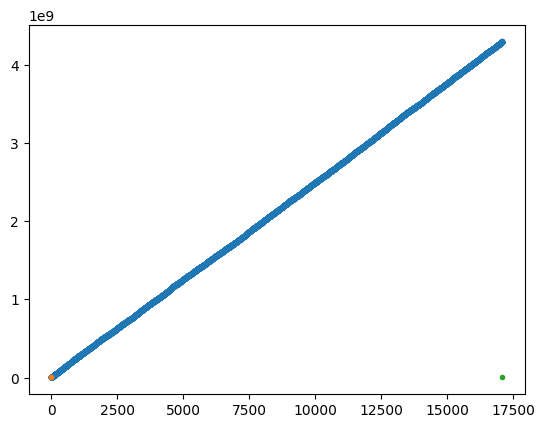

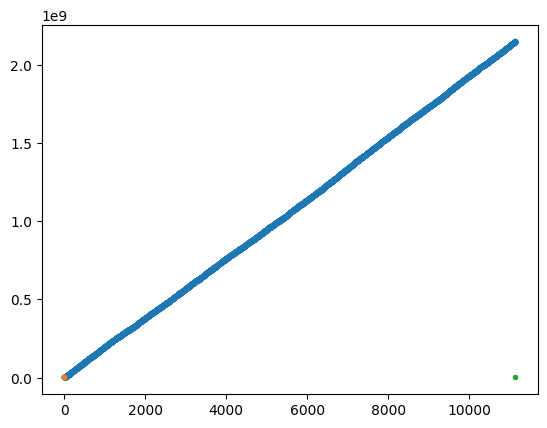

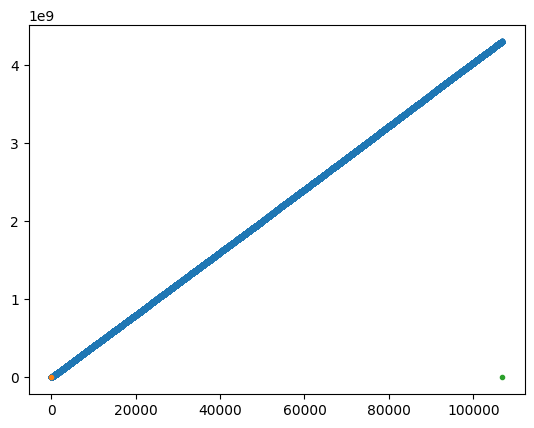

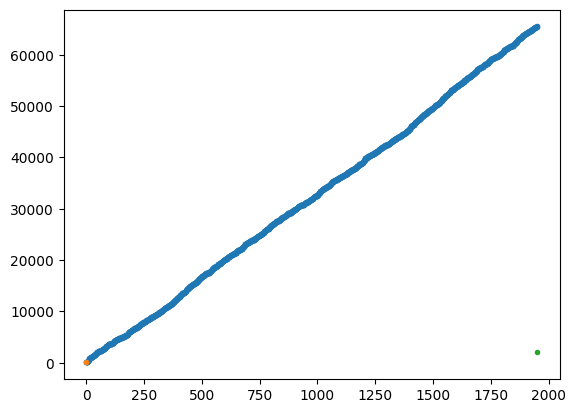

In [98]:
plt.close('all')
for colname in cols:
    plt.figure()
    v = df_meta[colname].unique()
    v.sort()
    plt.plot(v, '.')
    plt.plot([0], [v.min()], 'o', markersize=3)
    plt.plot([v.shape[0]], [v.min() + v.shape[0]], 'o', markersize=3)

array([[<Axes: title={'center': 'eeg_id'}>,
        <Axes: title={'center': 'spectrogram_id'}>],
       [<Axes: title={'center': 'label_id'}>,
        <Axes: title={'center': 'patient_id'}>]], dtype=object)

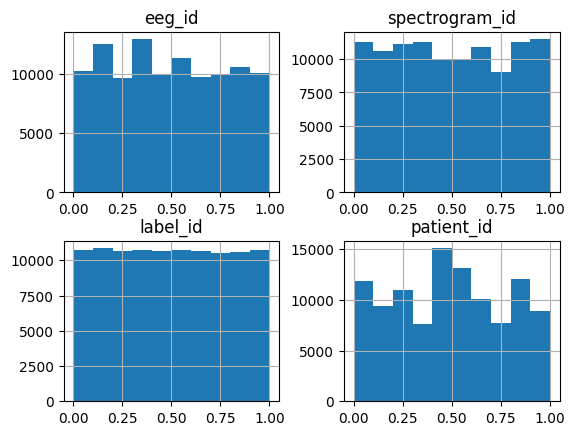

In [102]:
(df_meta[cols] / (df_meta[cols].max() - df_meta[cols].min())).hist()

*So, for a single EEG there is a single spectrogram, but for a single spectrogram there are multiple EEGs (a spectrogram covers 10 minutes, an EEG covers just 50-ish seconds).*

Is `('eeg_id', 'eeg_sub_id')` index?

In [5]:
df_meta \
    .groupby(['eeg_id', 'eeg_sub_id']) \
    .size().unique()

array([1], dtype=int64)

Is `('spectrogram_id', 'spectrogram_sub_id')` index?

In [6]:
df_meta \
    .groupby(['spectrogram_id', 'spectrogram_sub_id']) \
    .size().unique()

array([1], dtype=int64)

## Stats

Describe

In [157]:
df_meta.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes
count,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000
mean,2.104387e+09,26.286189,118.817228,1.067262e+09,43.733596,520.431404,2.141415e+09,32304.428493,0.208319,0.132120,0.128533,0.138913,0.179294,0.212822,7.255496
std,1.233371e+09,69.757658,314.557803,6.291475e+08,104.292116,1449.759868,1.241670e+09,18538.196252,0.378275,0.277731,0.276172,0.280059,0.336370,0.315197,5.645681
min,5.686570e+05,0.000000,0.000000,3.537330e+05,0.000000,0.000000,3.380000e+02,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.026896e+09,1.000000,6.000000,5.238626e+08,2.000000,12.000000,1.067419e+09,16707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,2.071326e+09,5.000000,26.000000,1.057904e+09,8.000000,62.000000,2.138332e+09,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,3.172787e+09,16.000000,82.000000,1.623195e+09,29.000000,394.000000,3.217816e+09,48036.000000,0.200000,0.066667,0.000000,0.076923,0.153846,0.333333,13.000000
max,4.294958e+09,742.000000,3372.000000,2.147388e+09,1021.000000,17632.000000,4.294934e+09,65494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000


Nans

In [156]:
df_meta.isna().sum()

eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
expert_consensus                    0
seizure_vote                        0
lpd_vote                            0
gpd_vote                            0
lrda_vote                           0
grda_vote                           0
other_vote                          0
n_votes                             0
dtype: int64

## Votes

Number of voters

In [67]:
df_meta['n_votes'].min(), df_meta['n_votes'].max()

(1, 28)

In [72]:
df_meta['n_votes'].value_counts().sort_index()

n_votes
1      4360
2      2316
3     51867
4      3451
5      3974
6       883
7         3
10     1146
11     2602
12     4356
13     7525
14     3887
15    10665
16     5191
17     1445
18     1934
19      250
20      634
21      179
22       54
23       24
24       17
25       20
26        6
27        5
28        6
Name: count, dtype: int64

<Axes: >

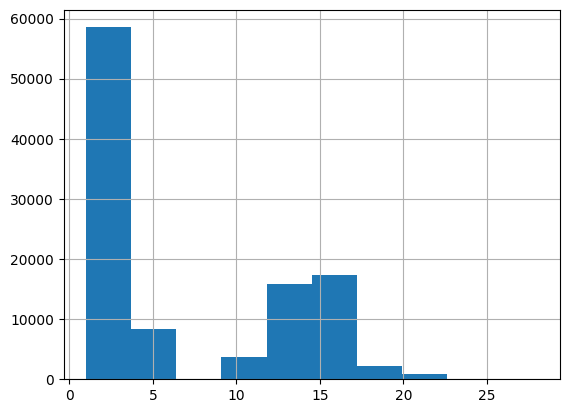

In [69]:
df_meta['n_votes'].hist()

Consensus values

In [65]:
df_meta['expert_consensus'].unique()

array(['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD'], dtype=object)

In [76]:
df_meta['expert_consensus'].value_counts().sort_values()

expert_consensus
LPD        14856
LRDA       16640
GPD        16702
Other      18808
GRDA       18861
Seizure    20933
Name: count, dtype: int64

How much different votes distributions are here inside a single `eeg_id`?

In [47]:
df_meta \
    .groupby(['eeg_id'])[vote_columns] \
    .apply(lambda x: np.unique(x, axis=0).shape[0]).unique()

array([ 1,  2,  5,  4,  3,  6, 37, 16,  8,  9, 12, 17,  7, 18, 10, 22, 11,
       25, 14, 27], dtype=int64)

In [58]:
df_meta \
    .groupby(['eeg_id'])[vote_columns] \
    .apply(lambda x: np.unique(x, axis=0).shape[0]).value_counts()

1     15533
2      1145
3       183
4        93
5        54
6        26
7        16
9        12
8         6
10        6
11        3
16        3
12        2
18        1
17        1
22        1
37        1
25        1
14        1
27        1
Name: count, dtype: int64

In [50]:
(df_meta \
    .groupby(['eeg_id'])[vote_columns] \
    .apply(lambda x: np.unique(x, axis=0).shape[0]) > 1).sum()

1556

How much different votes distributions are here inside a single `spectrogram_id`?

In [51]:
df_meta \
    .groupby(['spectrogram_id'])[vote_columns] \
    .apply(lambda x: np.unique(x, axis=0).shape[0]).unique()

array([ 1,  2,  3, 12,  5, 20,  4,  6,  7, 18,  8, 16, 10, 19, 33,  9, 43,
       13, 36, 11, 98, 14, 24, 69, 17, 45, 27, 38, 25, 35, 15, 54, 26],
      dtype=int64)

In [57]:
df_meta \
    .groupby(['spectrogram_id'])[vote_columns] \
    .apply(lambda x: np.unique(x, axis=0).shape[0]).value_counts()

1     9037
2     1459
3      312
4      133
5       55
6       42
7       30
9       14
8       10
10      10
13       5
12       4
16       3
18       2
20       2
36       2
11       2
45       1
54       1
15       1
35       1
25       1
38       1
27       1
43       1
17       1
69       1
24       1
14       1
98       1
33       1
19       1
26       1
Name: count, dtype: int64

In [52]:
(df_meta \
    .groupby(['spectrogram_id'])[vote_columns] \
    .apply(lambda x: np.unique(x, axis=0).shape[0]) > 1).sum()

2101

Sample from such `eeg_id`'s with disagreement

In [78]:
indices = []
df_meta \
    .groupby(['eeg_id'])[vote_columns] \
    .apply(lambda x: None if np.unique(x, axis=0).shape[0] == 1 else indices.append(x.name))
len(indices)

1556

In [61]:
id_ = np.random.choice(indices)
print(id_)
df_meta[df_meta['eeg_id'] == id_]

3591791883


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes
91776,3591791883,0,0.0,1863712617,522,10168.0,1251518560,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,1
91777,3591791883,1,42.0,1863712617,523,10210.0,2052444928,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91778,3591791883,2,48.0,1863712617,524,10216.0,171797593,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91779,3591791883,3,52.0,1863712617,525,10220.0,3766856629,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91780,3591791883,4,54.0,1863712617,526,10222.0,2882342387,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91781,3591791883,5,56.0,1863712617,527,10224.0,42742239,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91782,3591791883,6,58.0,1863712617,528,10226.0,613457630,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91783,3591791883,7,60.0,1863712617,529,10228.0,1970147158,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91784,3591791883,8,62.0,1863712617,530,10230.0,624388293,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3
91785,3591791883,9,66.0,1863712617,531,10234.0,2341723643,35225,LPD,0.0,1.000000,0.0,0.0,0.0,0.000000,3


In [119]:
row_order = [
    'lpd_vote', 
    'lrda_vote', 
    'gpd_vote', 
    'grda_vote',
    'seizure_vote', 
    'other_vote',
]
col_order = [
    'LPD',
    'LRDA',
    'GPD',
    'GRDA',
    'Seizure',
    'Other',
]

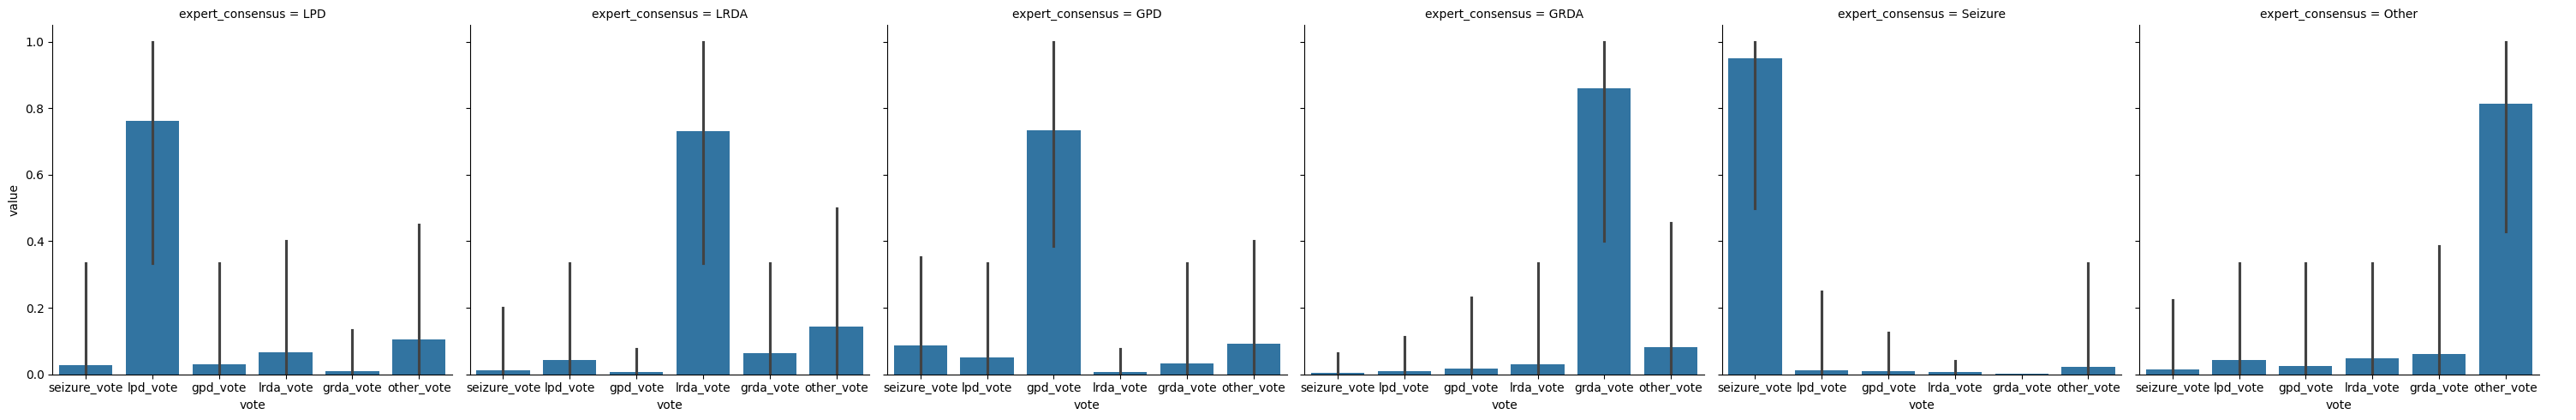

In [133]:
sns.catplot(
    data=df_meta.melt(
        id_vars='expert_consensus',
        value_vars=vote_columns,
        var_name='vote'
    ),
    x='vote',
    y='value',
    kind='bar',
    col='expert_consensus',
    col_order=col_order,
    errorbar='pi',
    n_boot=0,
)

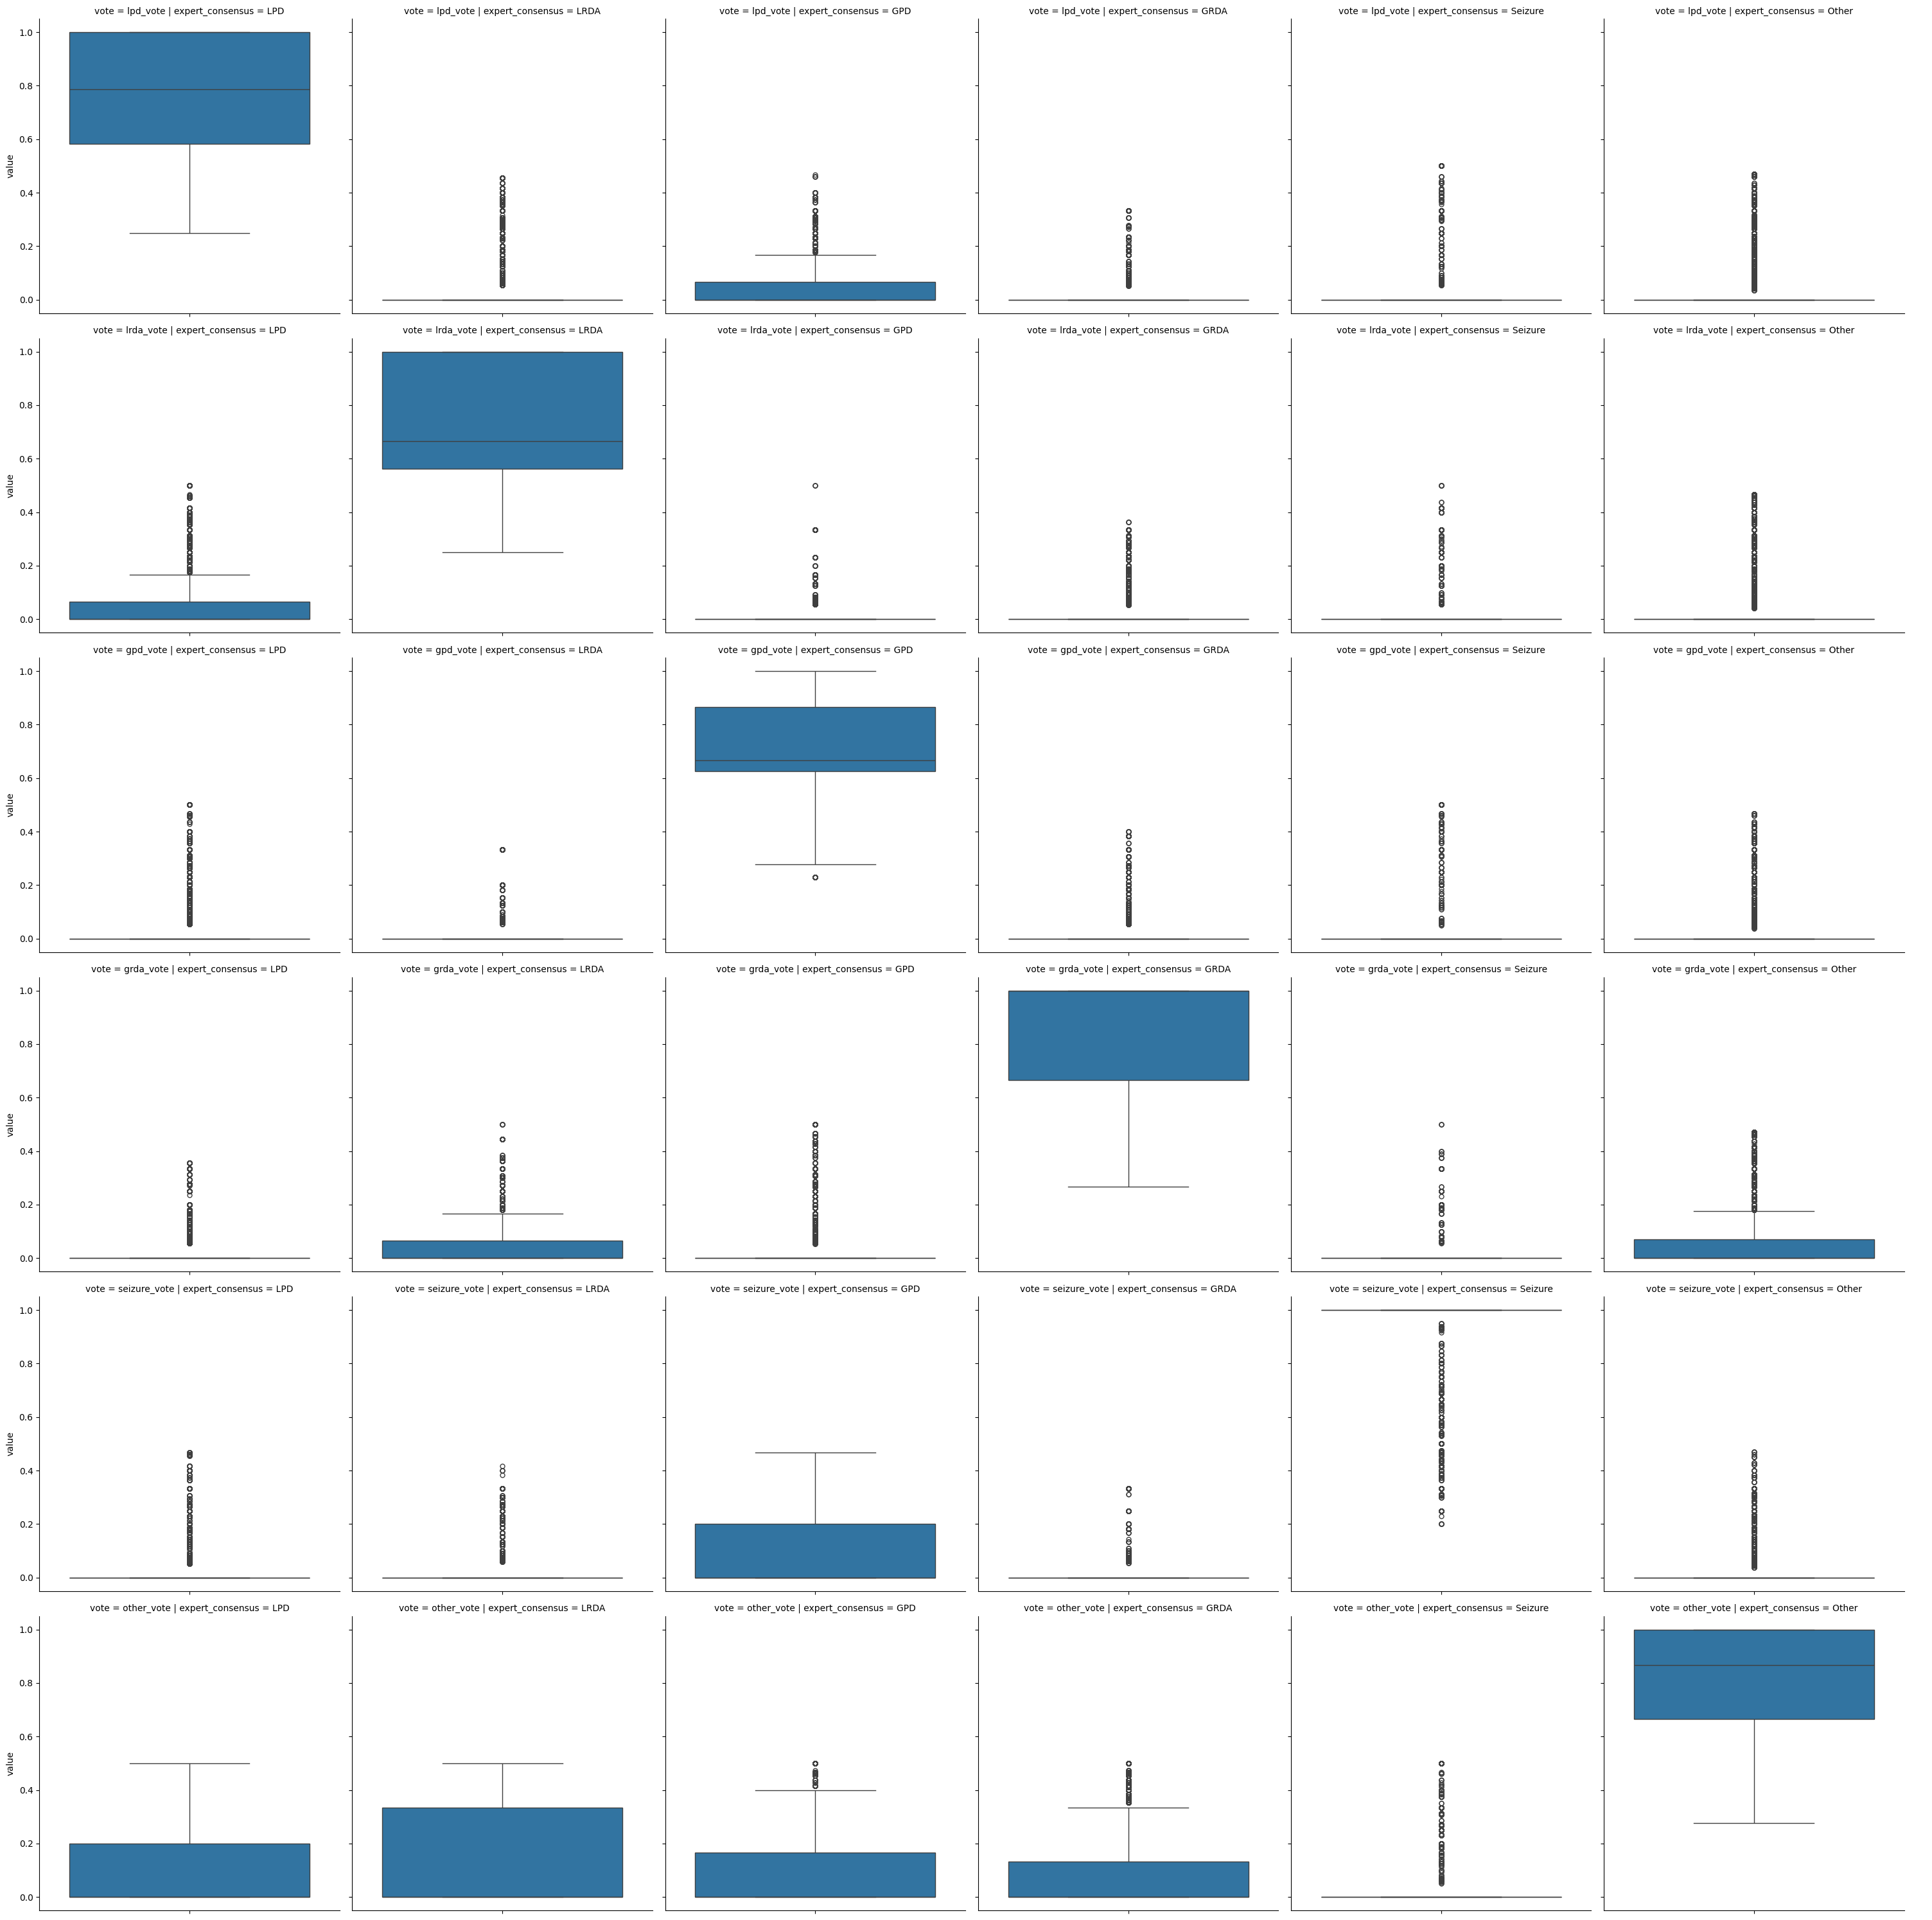

In [134]:
sns.catplot(
    data=df_meta.melt(
        id_vars='expert_consensus',
        value_vars=vote_columns,
        var_name='vote'
    ),
    y='value',
    kind='box',
    row='vote',
    row_order=row_order,
    col='expert_consensus',
    col_order=col_order,
)

<Axes: ylabel='expert_consensus'>

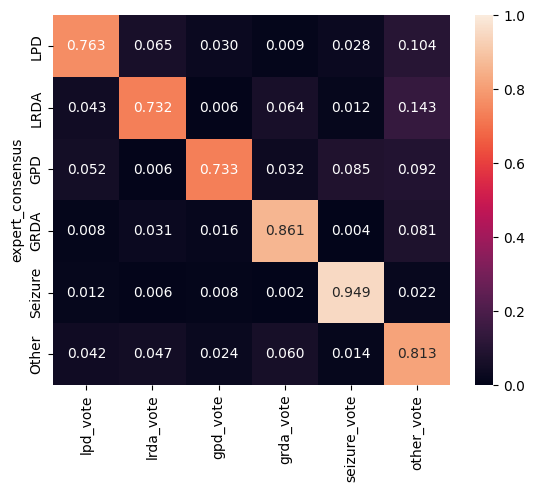

In [151]:
sns.heatmap(
    df_meta \
        .groupby('expert_consensus')[vote_columns] \
        .mean()\
        .reindex(col_order)[row_order],
    annot=True,
    fmt='.3f',
    vmin=0,
    vmax=1,
)

<Axes: ylabel='expert_consensus'>

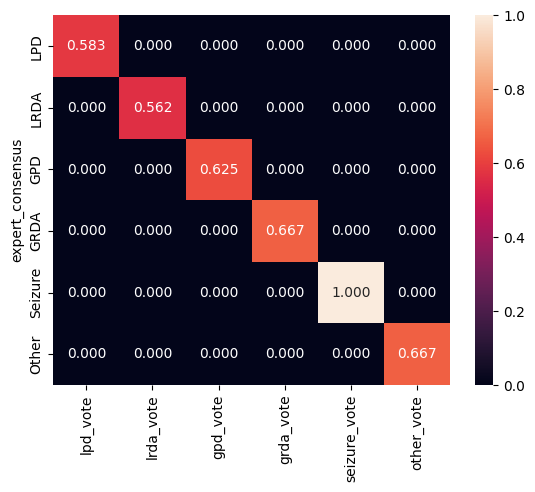

In [154]:
sns.heatmap(
    df_meta \
        .groupby('expert_consensus')[vote_columns] \
        .quantile(0.25)\
        .reindex(col_order)[row_order],
    annot=True,
    fmt='.3f',
    vmin=0,
    vmax=1,
)

<Axes: ylabel='expert_consensus'>

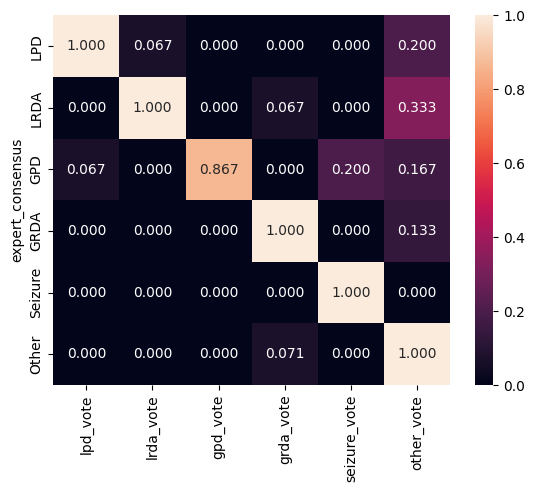

In [153]:
sns.heatmap(
    df_meta \
        .groupby('expert_consensus')[vote_columns] \
        .quantile(0.75)\
        .reindex(col_order)[row_order],
    annot=True,
    fmt='.3f',
    vmin=0,
    vmax=1,
)

# Spectrogram

Long spectrogram

In [120]:
df_meta[df_meta['spectrogram_id'] == 1841034439]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
90111,2597383367,0,0.0,1841034439,0,0.0,4234006534,32481,LRDA,1,0,0,2,0,1
90112,2597383367,1,2.0,1841034439,1,2.0,1205097964,32481,LRDA,1,0,0,2,0,1
90113,2597383367,2,4.0,1841034439,2,4.0,1967240574,32481,LRDA,1,0,0,2,0,1
90114,2597383367,3,6.0,1841034439,3,6.0,411140303,32481,LRDA,1,0,0,2,0,1
90115,2597383367,4,10.0,1841034439,4,10.0,1016767985,32481,LRDA,1,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90486,4039429016,5,36.0,1841034439,375,4450.0,3446987184,32481,Other,1,0,0,0,0,2
90487,4039429016,6,42.0,1841034439,376,4456.0,3824300406,32481,Other,2,0,0,1,0,16
90488,4039429016,7,48.0,1841034439,377,4462.0,233723906,32481,Other,2,0,0,1,0,16
90489,4039429016,8,88.0,1841034439,378,4502.0,1296067070,32481,Other,1,1,0,4,0,6


In [121]:
df_spectrogram = pd.read_parquet('train_spectrograms/1841034439.parquet')
df_spectrogram

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.940001,29.790001,29.520000,23.790001,14.830000,9.800000,8.060000,6.10,4.52,...,0.20,0.25,0.28,0.25,0.26,0.23,0.22,0.25,0.24,0.21
1,3,21.350000,28.330000,28.040001,22.090000,13.060000,7.210000,4.750000,4.81,3.39,...,0.28,0.29,0.33,0.24,0.19,0.21,0.16,0.16,0.18,0.26
2,5,12.090000,14.380000,13.250000,12.040000,8.100000,7.210000,5.490000,4.22,4.02,...,0.24,0.23,0.23,0.27,0.22,0.25,0.24,0.23,0.16,0.18
3,7,28.580000,29.879999,27.809999,22.520000,17.480000,11.540000,7.540000,5.76,4.36,...,0.40,0.40,0.35,0.20,0.25,0.29,0.31,0.24,0.23,0.19
4,9,99.239998,91.779999,75.250000,51.070000,29.590000,25.510000,17.520000,9.77,4.98,...,0.38,0.35,0.25,0.17,0.20,0.17,0.24,0.26,0.26,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,5139,70.870003,102.519997,98.669998,80.510002,61.389999,47.430000,24.379999,14.12,14.31,...,0.04,0.04,0.04,0.05,0.04,0.05,0.06,0.05,0.04,0.04
2570,5141,74.300003,81.779999,81.570000,60.070000,29.049999,20.200001,10.040000,7.55,9.38,...,0.08,0.07,0.07,0.04,0.05,0.07,0.05,0.04,0.05,0.04
2571,5143,34.169998,46.009998,55.950001,50.869999,46.840000,31.750000,11.120000,8.57,8.81,...,0.09,0.09,0.08,0.06,0.05,0.06,0.05,0.05,0.04,0.04
2572,5145,37.119999,57.840000,49.820000,57.730000,43.419998,28.629999,19.250000,8.63,6.89,...,0.02,0.01,0.02,0.02,0.03,0.03,0.03,0.04,0.03,0.04


In [122]:
df_spectrogram.isna().sum()

time        0
LL_0.59     0
LL_0.78     0
LL_0.98     0
LL_1.17     0
           ..
RP_19.14    0
RP_19.34    0
RP_19.53    0
RP_19.73    0
RP_19.92    0
Length: 401, dtype: int64

In [18]:
df_spectrogram.describe()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
count,2574.00000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,...,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000
mean,2574.00000,363.934113,418.072266,409.633972,280.958130,208.469162,132.638153,89.820793,64.176003,43.610985,...,1.772801,1.783535,1.595808,1.183982,1.262277,1.389604,1.838007,2.138749,2.012925,2.199600
std,1486.38824,4514.385254,5679.765137,6248.649902,4684.504883,4007.149658,2551.088135,1615.275269,1081.241089,696.268066,...,33.606468,33.145725,26.182976,17.835421,20.072636,22.094173,32.596581,39.675591,36.761066,41.778973
min,1.00000,2.250000,3.330000,2.850000,2.460000,1.750000,1.140000,0.860000,0.500000,0.500000,...,0.010000,0.010000,0.010000,0.020000,0.020000,0.010000,0.020000,0.020000,0.010000,0.010000
25%,1287.50000,22.770000,26.139999,25.195000,18.170000,12.162500,8.612500,6.090000,4.492500,3.405000,...,0.070000,0.070000,0.070000,0.070000,0.070000,0.060000,0.060000,0.060000,0.060000,0.060000
50%,2574.00000,41.125000,46.515001,44.450001,33.184999,22.490000,15.880000,11.720000,9.270000,7.190000,...,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.110000,0.110000,0.110000,0.110000
75%,3860.50000,68.865000,75.815001,71.447500,54.660000,38.809999,30.467500,24.760000,19.957500,16.057499,...,0.310000,0.300000,0.300000,0.290000,0.290000,0.280000,0.280000,0.280000,0.270000,0.270000
max,5147.00000,150216.078125,181842.718750,213724.062500,151504.031250,133117.703125,87895.398438,51563.511719,30513.009766,25569.179688,...,1391.979980,1360.939941,932.789978,588.320007,674.690002,693.950012,950.520020,1407.160034,1315.719971,1536.910034


In [35]:
df_spectrogram.quantile(0.99).max()

1128.105224609375

In [69]:
df_tmp = df_spectrogram.melt(
    id_vars=[],
    value_vars=df_spectrogram.columns.difference(['time']),
)
df_tmp

,variable,value
0,LL_0.59,28.940001
1,LL_0.59,21.350000
2,LL_0.59,12.090000
3,LL_0.59,28.580000
4,LL_0.59,99.239998
...,...,...
1029595,RP_9.96,0.340000
1029596,RP_9.96,0.280000
1029597,RP_9.96,0.150000
1029598,RP_9.96,0.200000


In [70]:
q99 = df_tmp['value'].quantile(0.99)
df_tmp.loc[df_tmp['value'] > q99, 'value'] = q99
q99

C:\Users\mkoty\AppData\Local\Temp\ipykernel_10008\3187336161.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '191.00009994506846' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_tmp.loc[df_tmp['value'] > q99, 'value'] = q99


191.00009994506846

(array([2.20508e+05, 2.31248e+05, 1.32993e+05, 9.12070e+04, 6.31990e+04,
        4.56640e+04, 3.44290e+04, 2.71200e+04, 2.05450e+04, 1.67440e+04,
        1.37860e+04, 1.12090e+04, 9.88500e+03, 8.91500e+03, 8.31900e+03,
        7.94400e+03, 7.72800e+03, 7.20500e+03, 6.84000e+03, 6.43700e+03,
        5.92200e+03, 5.66500e+03, 5.20200e+03, 4.75000e+03, 4.34500e+03,
        3.96900e+03, 3.48000e+03, 3.04400e+03, 2.47400e+03, 2.07400e+03,
        1.59300e+03, 1.35600e+03, 1.06700e+03, 9.75000e+02, 9.30000e+02,
        7.44000e+02, 6.95000e+02, 6.99000e+02, 6.38000e+02, 5.93000e+02,
        5.12000e+02, 5.08000e+02, 4.73000e+02, 4.44000e+02, 4.36000e+02,
        3.61000e+02, 3.92000e+02, 3.46000e+02, 2.99000e+02, 2.64000e+02,
        2.55000e+02, 2.41000e+02, 2.41000e+02, 2.06000e+02, 2.26000e+02,
        1.82000e+02, 2.12000e+02, 1.67000e+02, 1.71000e+02, 1.75000e+02,
        1.30000e+02, 8.90000e+01, 9.10000e+01, 9.90000e+01, 7.30000e+01,
        6.40000e+01, 5.10000e+01, 5.10000e+01, 4.90

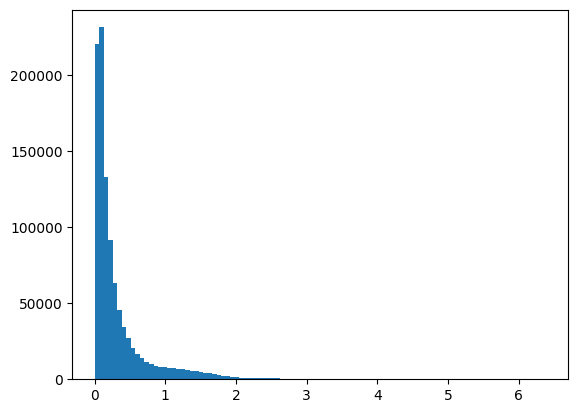

In [84]:
plt.hist(np.log10(df_spectrogram[df_spectrogram.columns.difference(['time'])].values.flatten() + 1), bins=100)

In [76]:
df_spectrogram.columns.difference(['time'])

Index(['LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56',
       'LL_1.76', 'LL_1.95', 'LL_10.16', 'LL_10.35',
       ...
       'RP_8.2', 'RP_8.4', 'RP_8.59', 'RP_8.79', 'RP_8.98', 'RP_9.18',
       'RP_9.38', 'RP_9.57', 'RP_9.77', 'RP_9.96'],
      dtype='object', length=400)

In [91]:
df_spectrogram[
    df_spectrogram[df_spectrogram.columns.difference(['time'])] > 1000
] = np.nan
df_spectrogram

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.940001,29.790001,29.520000,23.790001,14.830000,9.800000,8.060000,6.10,4.52,...,0.20,0.25,0.28,0.25,0.26,0.23,0.22,0.25,0.24,0.21
1,3,21.350000,28.330000,28.040001,22.090000,13.060000,7.210000,4.750000,4.81,3.39,...,0.28,0.29,0.33,0.24,0.19,0.21,0.16,0.16,0.18,0.26
2,5,12.090000,14.380000,13.250000,12.040000,8.100000,7.210000,5.490000,4.22,4.02,...,0.24,0.23,0.23,0.27,0.22,0.25,0.24,0.23,0.16,0.18
3,7,28.580000,29.879999,27.809999,22.520000,17.480000,11.540000,7.540000,5.76,4.36,...,0.40,0.40,0.35,0.20,0.25,0.29,0.31,0.24,0.23,0.19
4,9,99.239998,91.779999,75.250000,51.070000,29.590000,25.510000,17.520000,9.77,4.98,...,0.38,0.35,0.25,0.17,0.20,0.17,0.24,0.26,0.26,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,5139,70.870003,102.519997,98.669998,80.510002,61.389999,47.430000,24.379999,14.12,14.31,...,0.04,0.04,0.04,0.05,0.04,0.05,0.06,0.05,0.04,0.04
2570,5141,74.300003,81.779999,81.570000,60.070000,29.049999,20.200001,10.040000,7.55,9.38,...,0.08,0.07,0.07,0.04,0.05,0.07,0.05,0.04,0.05,0.04
2571,5143,34.169998,46.009998,55.950001,50.869999,46.840000,31.750000,11.120000,8.57,8.81,...,0.09,0.09,0.08,0.06,0.05,0.06,0.05,0.05,0.04,0.04
2572,5145,37.119999,57.840000,49.820000,57.730000,43.419998,28.629999,19.250000,8.63,6.89,...,0.02,0.01,0.02,0.02,0.03,0.03,0.03,0.04,0.03,0.04


In [92]:
df_spectrogram.isna().sum()

time         0
LL_0.59     81
LL_0.78     80
LL_0.98     68
LL_1.17     46
            ..
RP_19.14     0
RP_19.34     0
RP_19.53     2
RP_19.73     1
RP_19.92     2
Length: 401, dtype: int64

In [53]:
df_spectrogram.iloc[:30]

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.680000,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,...,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
1,3,29.639999,38.959999,44.009998,66.800003,48.509998,42.180000,47.340000,48.599998,40.880001,...,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
2,5,8.890000,9.020000,16.360001,23.559999,27.340000,30.040001,27.559999,23.290001,15.120000,...,0.12,0.11,0.08,0.08,0.09,0.10,0.12,0.14,0.13,0.14
3,7,1.770000,1.930000,1.810000,1.600000,1.430000,1.280000,1.190000,1.110000,1.010000,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
natsorted(df_spectrogram.columns.difference(['time']))

['LL_0.59',
 'LL_0.78',
 'LL_0.98',
 'LL_1.17',
 'LL_1.37',
 'LL_1.56',
 'LL_1.76',
 'LL_1.95',
 'LL_2.15',
 'LL_2.34',
 'LL_2.54',
 'LL_2.73',
 'LL_2.93',
 'LL_3.13',
 'LL_3.32',
 'LL_3.52',
 'LL_3.71',
 'LL_3.91',
 'LL_4.1',
 'LL_4.3',
 'LL_4.49',
 'LL_4.69',
 'LL_4.88',
 'LL_5.08',
 'LL_5.27',
 'LL_5.47',
 'LL_5.66',
 'LL_5.86',
 'LL_6.05',
 'LL_6.25',
 'LL_6.45',
 'LL_6.64',
 'LL_6.84',
 'LL_7.03',
 'LL_7.23',
 'LL_7.42',
 'LL_7.62',
 'LL_7.81',
 'LL_8.01',
 'LL_8.2',
 'LL_8.4',
 'LL_8.59',
 'LL_8.79',
 'LL_8.98',
 'LL_9.18',
 'LL_9.38',
 'LL_9.57',
 'LL_9.77',
 'LL_9.96',
 'LL_10.16',
 'LL_10.35',
 'LL_10.55',
 'LL_10.74',
 'LL_10.94',
 'LL_11.13',
 'LL_11.33',
 'LL_11.52',
 'LL_11.72',
 'LL_11.91',
 'LL_12.3',
 'LL_12.5',
 'LL_12.7',
 'LL_12.11',
 'LL_12.89',
 'LL_13.09',
 'LL_13.28',
 'LL_13.48',
 'LL_13.67',
 'LL_13.87',
 'LL_14.06',
 'LL_14.26',
 'LL_14.45',
 'LL_14.65',
 'LL_14.84',
 'LL_15.04',
 'LL_15.23',
 'LL_15.43',
 'LL_15.63',
 'LL_15.82',
 'LL_16.02',
 'LL_16.6',
 'LL

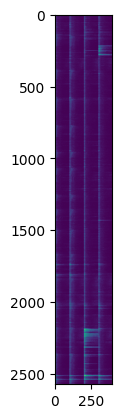

In [95]:
plt.imshow(np.log10(df_spectrogram[natsorted(df_spectrogram.columns.difference(['time']))].values + 1))

Short single spectrogram

In [123]:
df_meta[df_meta['spectrogram_id'] == 1000086677]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
51004,2982836004,0,0.0,1000086677,0,0.0,1192143167,48272,Other,0,0,0,0,0,1


In [124]:
df_spectrogram = pd.read_parquet('train_spectrograms/1000086677.parquet')
df_spectrogram

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.680000,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,...,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
1,3,29.639999,38.959999,44.009998,66.800003,48.509998,42.180000,47.340000,48.599998,40.880001,...,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
2,5,8.890000,9.020000,16.360001,23.559999,27.340000,30.040001,27.559999,23.290001,15.120000,...,0.12,0.11,0.08,0.08,0.09,0.10,0.12,0.14,0.13,0.14
3,7,1.770000,1.930000,1.810000,1.600000,1.430000,1.280000,1.190000,1.110000,1.010000,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,591,2.210000,2.280000,2.200000,1.280000,1.350000,1.930000,2.300000,2.440000,2.310000,...,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.03,0.03
296,593,2.490000,2.540000,2.150000,1.490000,1.360000,1.570000,1.970000,2.050000,1.890000,...,0.02,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0.01
297,595,0.240000,0.190000,0.210000,0.120000,0.110000,0.080000,0.060000,0.040000,0.040000,...,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00
298,597,0.990000,1.230000,1.370000,1.620000,1.940000,2.190000,2.270000,2.310000,2.300000,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


In [125]:
df_spectrogram.describe()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
count,300.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,...,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,300.000000,233.232529,279.460327,270.970123,210.139755,157.189560,120.130547,95.375908,77.097679,63.031826,...,1.730401,1.655365,1.585694,1.565511,1.506788,1.482007,1.481058,1.445182,1.421350,1.397153
std,173.493516,2676.831055,3192.628662,3090.084229,2371.168945,1745.350830,1310.048096,1023.178955,814.986145,657.229370,...,17.462353,16.827236,16.122868,15.982046,15.489975,15.294032,15.292485,14.925896,14.667584,14.367368
min,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,150.500000,0.292500,0.292500,0.310000,0.172500,0.120000,0.100000,0.080000,0.070000,0.060000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.000000
50%,300.000000,2.090000,2.740000,3.390000,3.225000,3.385000,3.255000,3.160000,3.100000,3.155000,...,0.050000,0.040000,0.040000,0.040000,0.040000,0.030000,0.035000,0.040000,0.040000,0.035000
75%,449.500000,6.295000,9.237500,13.420000,13.950001,16.125000,15.157500,15.262500,13.787499,13.057500,...,0.300000,0.292500,0.280000,0.287500,0.287500,0.290000,0.277500,0.280000,0.290000,0.307500
max,599.000000,35956.378906,41827.039062,40584.359375,31084.390625,22541.839844,16987.730469,13323.349609,10678.360352,8780.129883,...,227.330002,220.850006,216.669998,211.179993,208.110001,203.149994,199.559998,194.229996,190.139999,185.330002


In [126]:
df_spectrogram.isna().sum()

time         0
LL_0.59     26
LL_0.78     26
LL_0.98     26
LL_1.17     26
            ..
RP_19.14    26
RP_19.34    26
RP_19.53    26
RP_19.73    26
RP_19.92    26
Length: 401, dtype: int64

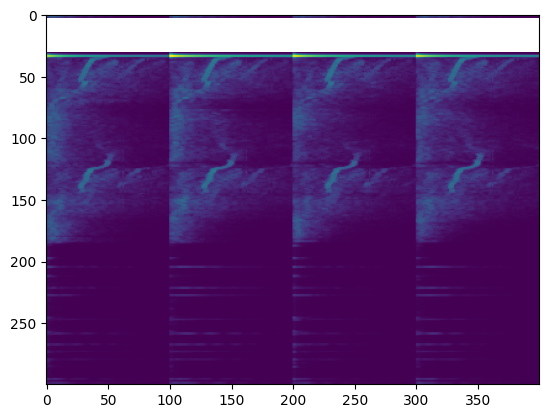

In [127]:
plt.imshow(np.log10(df_spectrogram[natsorted(df_spectrogram.columns.difference(['time']))].values + 1))

# EEG

In [96]:
df_meta[df_meta['eeg_id'] == 1628180742]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0


In [97]:
df_eeg = pd.read_parquet('train_eegs/1628180742.parquet')
df_eeg

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
17996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
17997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
17998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


In [101]:
df_eeg.values.shape

(18000, 20)

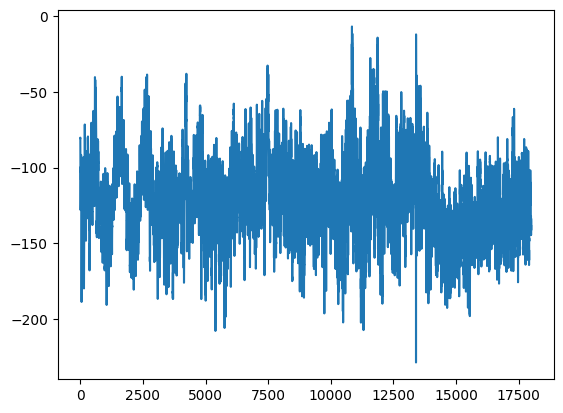

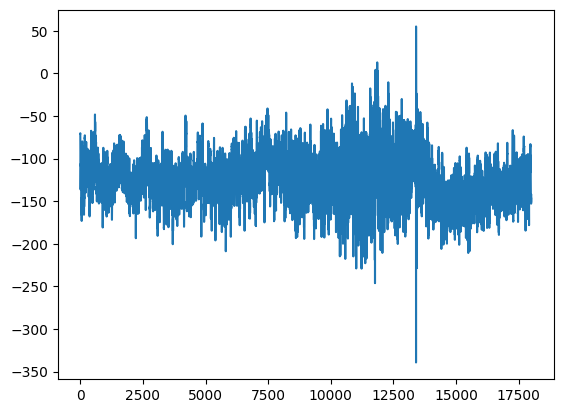

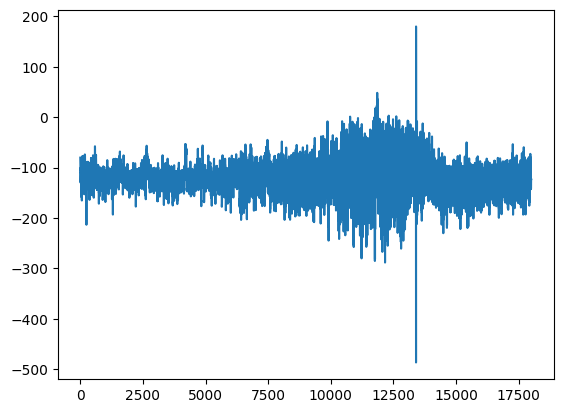

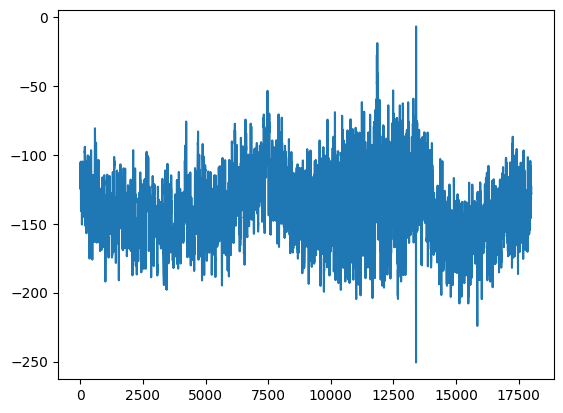

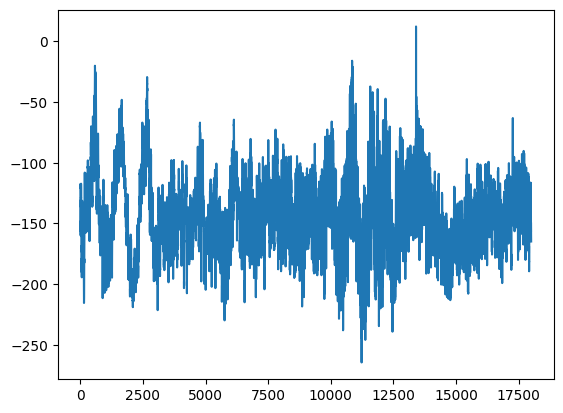

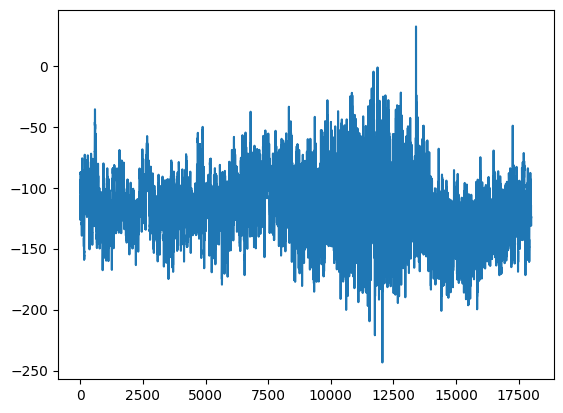

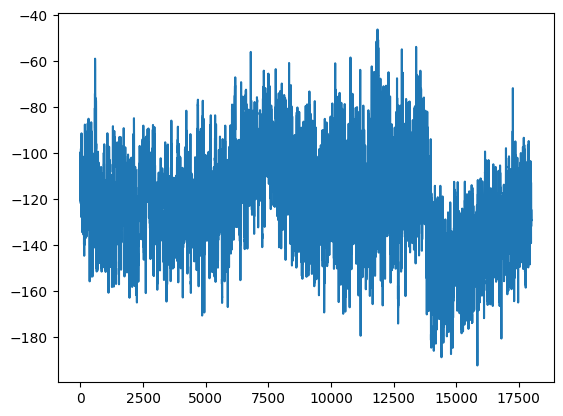

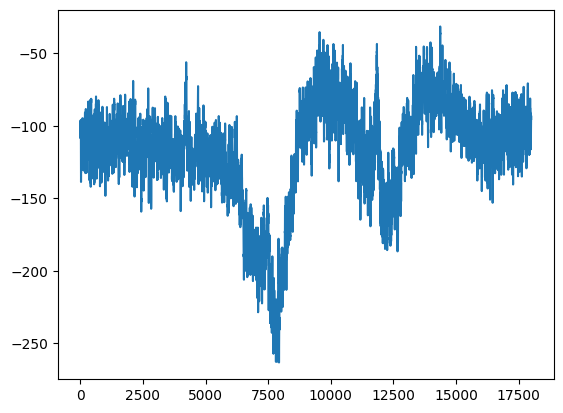

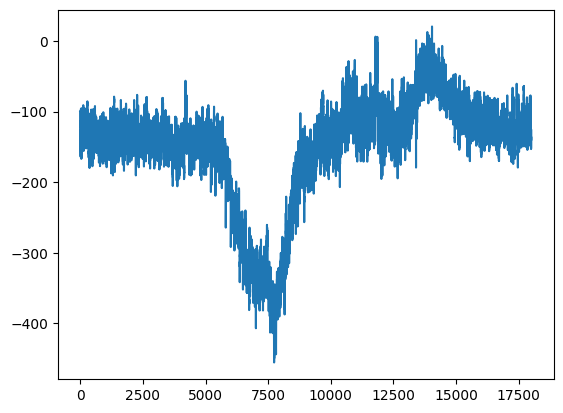

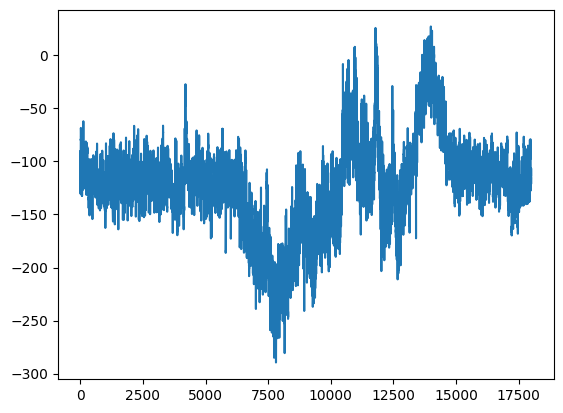

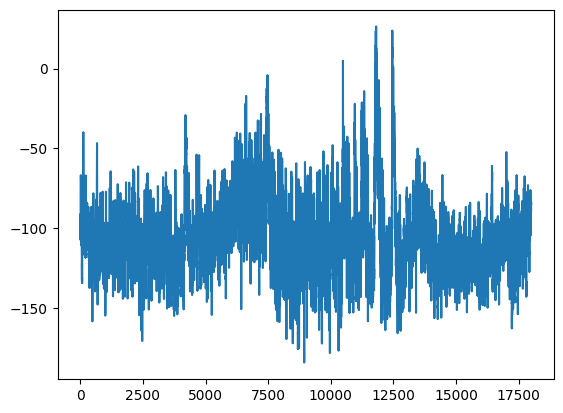

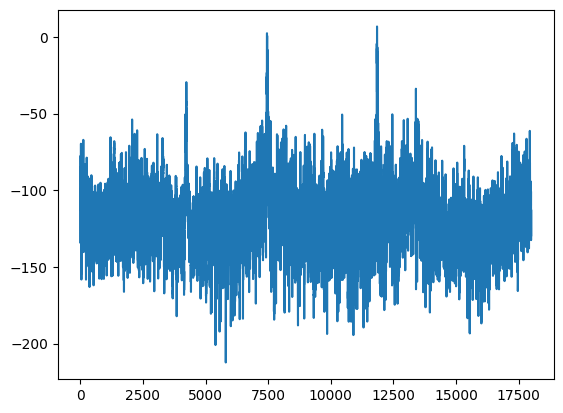

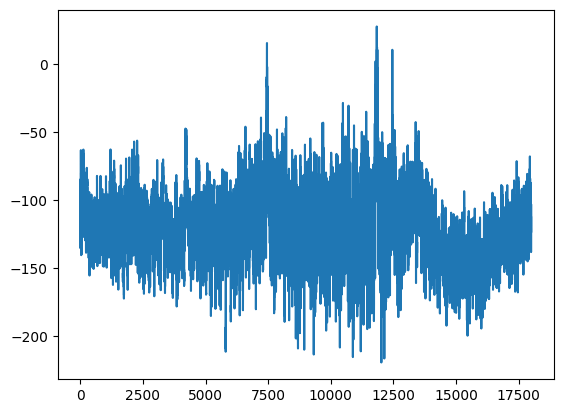

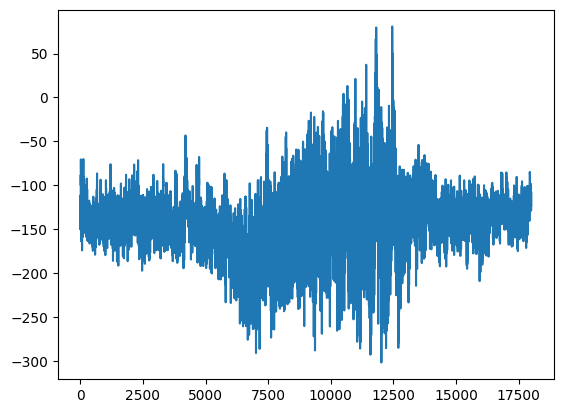

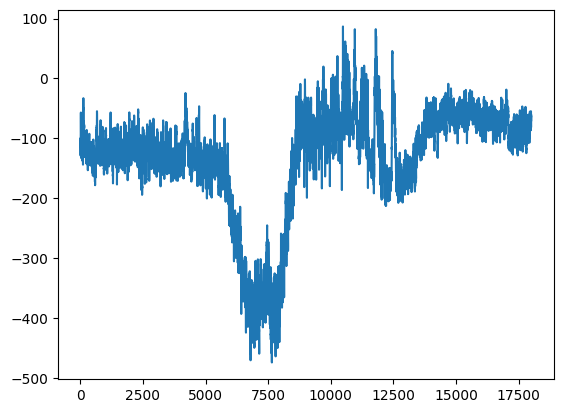

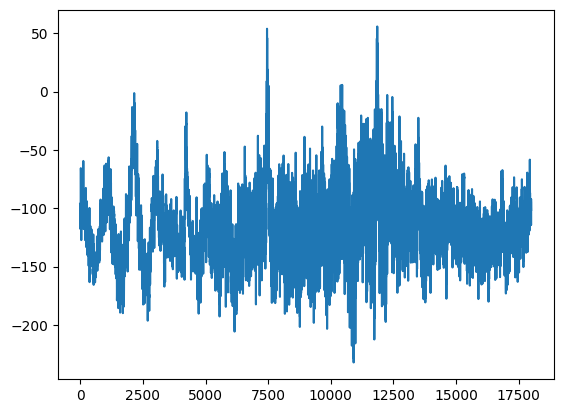

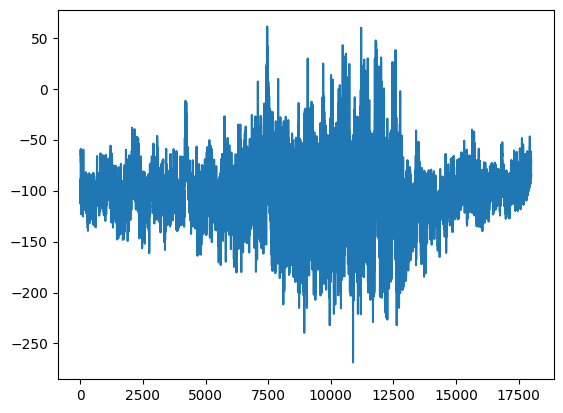

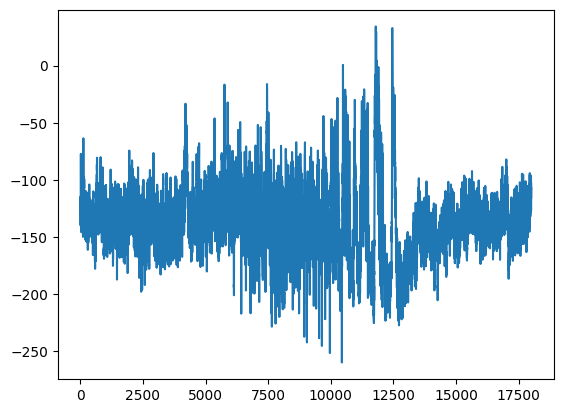

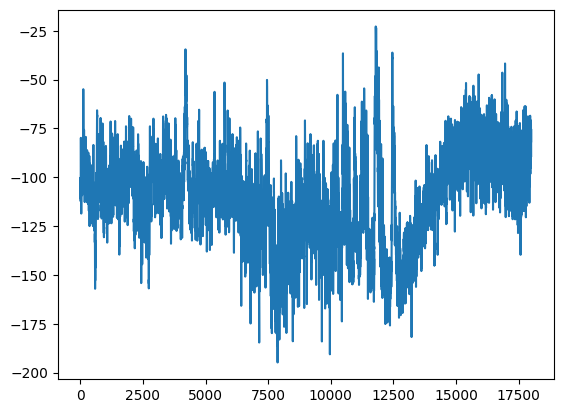

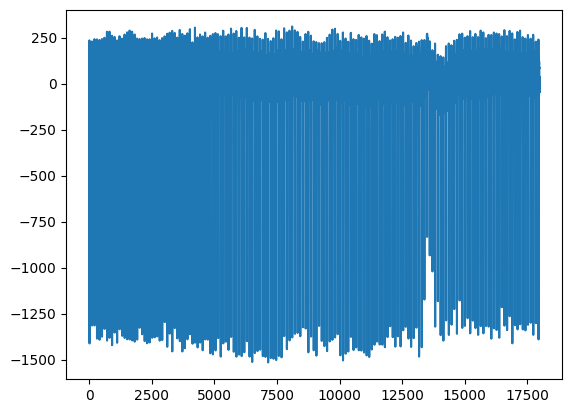

In [106]:
for col in df_eeg.columns:
    plt.figure()
    plt.plot(df_eeg[col])

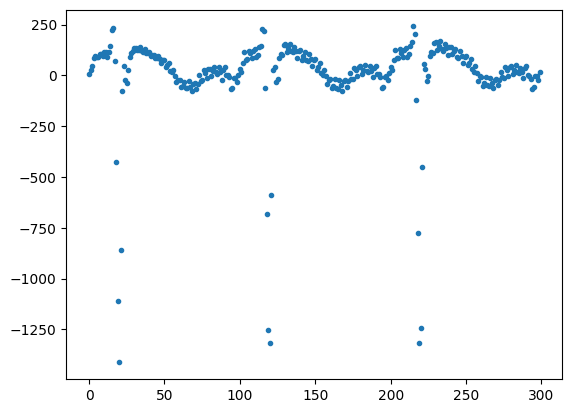

In [117]:
plt.plot(df_eeg['EKG'].iloc[:300], '.')

In [13]:
eeg_length_s = 18000/200  # sampling rate is 200 Hz
eeg_length_s

90.0

In [14]:
eeg_length_s = 10000/200  # sampling rate is 200 Hz
eeg_length_s

50.0

# Transformer

In [4]:
model = HmsClassifier(
    n_classes=6,
    input_dim_s=100,
    num_patches_s=1200,
    input_dim_e=200,
    num_patches_e=1000,
    embed_dim=128,
    num_heads=4,
    dropout=0.1,
    depth=2,
)

In [5]:
x_s = torch.rand(16, 4, 300, 100)
x_e = torch.rand(16, 50, 200, 20)
x = model(x_s, x_e)
x.shape

tensor([[-0.0575,  0.8144,  0.0676, -0.0260,  0.0407,  0.2013],
        [-0.4613,  0.6967, -0.3040, -0.0973, -0.0326,  0.2200],
        [-0.3948,  0.8187,  0.0571, -0.1056,  0.2672,  0.1780],
        [-0.1352,  0.2019,  0.1374,  0.1077, -0.0140,  0.1474],
        [-0.2614,  0.5350,  0.1953,  0.2566, -0.1112,  0.1097],
        [-0.4594,  0.6676, -0.0257, -0.0496,  0.0963,  0.1518],
        [-0.5209,  0.6715,  0.0655,  0.0074,  0.1231,  0.0992],
        [-0.1682,  0.8333,  0.0812, -0.2938,  0.1737,  0.4833],
        [-0.3500,  0.5426,  0.0919, -0.1659,  0.2900,  0.0713],
        [-0.1918,  0.4973,  0.1325, -0.0464, -0.1923,  0.0887],
        [-0.0474,  0.3032,  0.4165, -0.0799,  0.2060, -0.0655],
        [-0.2090,  0.5822,  0.0487, -0.1592, -0.0947,  0.0721],
        [-0.3060,  0.4402,  0.4489,  0.0361,  0.0960,  0.4445],
        [-0.1578,  0.3537, -0.1456, -0.1459,  0.2042,  0.1521],
        [-0.2624,  0.5499,  0.1771, -0.0132,  0.0802,  0.0195],
        [-0.4538,  0.4829, -0.4469, -0.0